<a href="https://colab.research.google.com/github/Rohianon/ImageClassificationProjects/blob/main/Honey_Bees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(1)
import random

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import  keras
from IPython.display import  clear_output
import numpy as np
import pandas as pd
import pathlib

from sklearn.metrics import classification_report, confusion_matrix

# Reproducible Results
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)
# from numpy.random import seed
# seed(1234)
# tf.random.set_seed(245)


In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
! unzip honeybees.zip

Streaming output truncated to the last 5000 lines.
  inflating: bees/test/category1/010_493.png  
  inflating: bees/test/category1/010_497.png  
  inflating: bees/test/category1/010_508.png  
  inflating: bees/test/category1/010_533.png  
  inflating: bees/test/category1/010_535.png  
  inflating: bees/test/category1/010_552.png  
  inflating: bees/test/category1/010_573.png  
  inflating: bees/test/category1/010_590.png  
  inflating: bees/test/category1/010_633.png  
  inflating: bees/test/category1/010_638.png  
  inflating: bees/test/category1/010_644.png  
  inflating: bees/test/category1/010_656.png  
  inflating: bees/test/category1/010_657.png  
  inflating: bees/test/category1/010_706.png  
  inflating: bees/test/category1/010_718.png  
  inflating: bees/test/category1/010_721.png  
  inflating: bees/test/category1/010_731.png  
  inflating: bees/test/category1/010_752.png  
  inflating: bees/test/category1/010_778.png  
  inflating: bees/test/category1/010_779.png  
  inflati

In [ ]:
PATH = '/content/bees-simple/bees'
train_path = pathlib.Path(PATH+'/train')
valid_path = pathlib.Path(PATH+'/validate')
test_path = pathlib.Path(PATH+'/test')

data_paths = [train_path, valid_path, test_path]
classes = os.listdir(test_path)

In [ ]:
# static Variables
IMG_WIDTH, IMG_HEIGHT, CHANNELS = 48, 48, 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_CLASSES = len(classes)
BATCH_SIZE = 32
CLASS_NAMES = np.array([item.name for item in test_path.glob('*')])


In [ ]:
def create_dataset(data_dir=train_path):
    list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.png'))
    size = len(list(list_ds))
    print('Size of your dataset is', size)
  
    return list_ds, size



In [ ]:
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def get_label_one_hot(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES


def get_label(file_path):
    return tf.strings.split(file_path, os.path.sep)[-2]
    

def process_path(file_path):
    label = get_label_one_hot(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    reset_random_seeds()
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


## Progressive Resizing- reduces training time 

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(7,7))
    for n in range(9):
        ax = plt.subplot(3,3,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [ ]:

class PlotLearning(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        reset_random_seeds()
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        reset_random_seeds()
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,9), sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.set_title('Loss Curve')
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.set_title('Accuracy Curve')
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [ ]:
df1, TRAIN_SIZE = create_dataset()
df2, VALID_SIZE = create_dataset(valid_path)
df3, TEST_SIZE = create_dataset(test_path)

Size of your dataset is 4143
Size of your dataset is 500
Size of your dataset is 500


In [ ]:
def modelfit(model, train_set, eval_set, save='trained_default.h5'):
    reset_random_seeds()
    model.compile(optimizer='adam',
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

    train_batch = TRAIN_SIZE//BATCH_SIZE
    eval_batch = VALID_SIZE//BATCH_SIZE

    model.fit(train_set,
                steps_per_epoch=train_batch,
                validation_data=eval_set,
                validation_steps=eval_batch,
                epochs=30,
                verbose=1,
                shuffle=False,
                callbacks=[plot])

    model.save(save)
    
    return model

In [ ]:
def load_image(ds1, ds2, ds3):
    reset_random_seeds()
    labeled_ds1 = ds1.map(process_path, num_parallel_calls=AUTOTUNE)
    labeled_ds2 = ds2.map(process_path, num_parallel_calls=AUTOTUNE)
    labeled_ds3 = ds3.map(process_path, num_parallel_calls=AUTOTUNE)

    ds1 = prepare_for_training(labeled_ds1)
    ds2 = prepare_for_training(labeled_ds2)
    ds3 = prepare_for_training(labeled_ds2)

    train_ds = ds1.take(TRAIN_SIZE)
    eval_ds = ds2.take(VALID_SIZE)
    test_ds = ds3.take(TEST_SIZE)

    # Example data with label
    example_batch, example_label_batch = next(iter(train_ds))
    show_batch(example_batch.numpy(), example_label_batch.numpy())
    
    return train_ds, eval_ds, test_ds

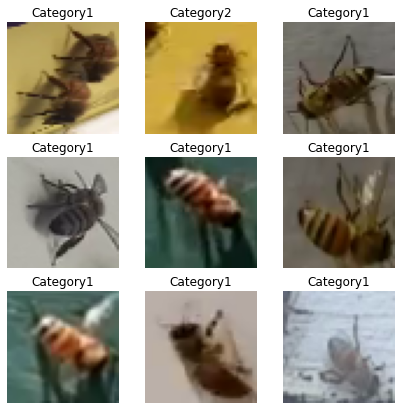

In [ ]:
train_ds, eval_ds, test_ds = load_image(df1, df2, df3)

In [ ]:
img_shape=(IMG_HEIGHT, IMG_HEIGHT, 3)
reset_random_seeds()
model48 = keras.Sequential()

model48.add(keras.layers.Conv2D(64, 3, input_shape=(img_shape), activation='relu'))
model48.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation='relu'))
model48.add(keras.layers.Dropout(0.2))
model48.add(keras.layers.MaxPool2D())
model48.add(keras.layers.BatchNormalization())

model48.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation='relu'))
model48.add(keras.layers.Dropout(0.2))
model48.add(keras.layers.MaxPool2D())
model48.add(keras.layers.Flatten())
model48.add(keras.layers.Dropout(0.2))

model48.add(keras.layers.Dense(1024, activation='relu'))
model48.add(keras.layers.Dense(512, activation='relu'))
model48.add(keras.layers.Dense(NUM_CLASSES, activation='softmax'))

model48.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

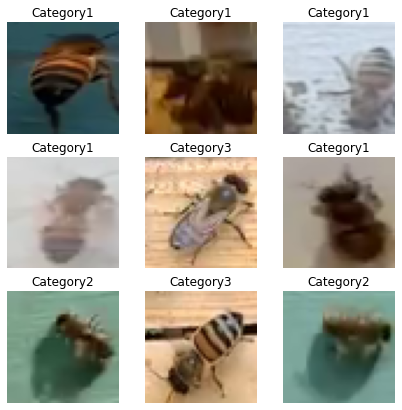

In [ ]:
train_ds_48, eval_ds_48, test_ds_48 = load_image(df1, df2, df3)


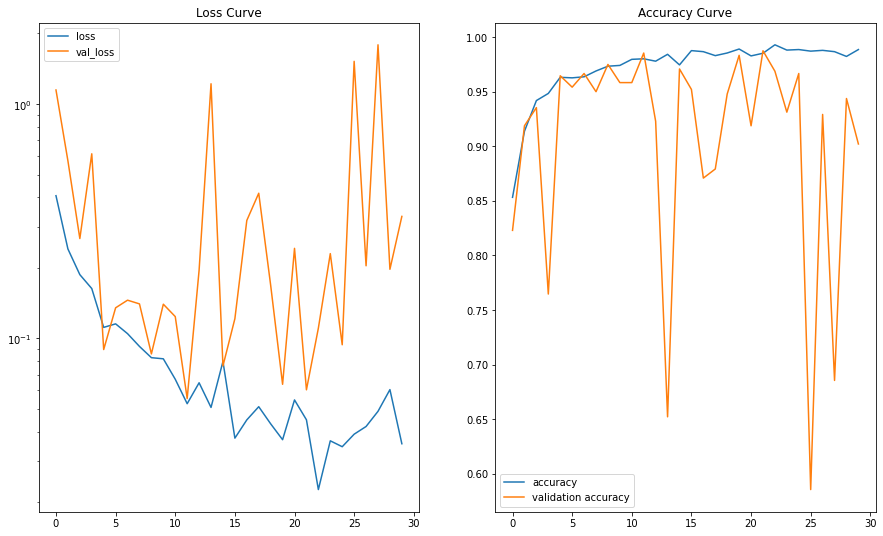

In [ ]:
reset_random_seeds()
model48 = modelfit(model48, train_ds_48, eval_ds_48, save='trained_48.h5')

In [ ]:
def print_final_accuracy(model = model48, holdout=eval_ds_48, test = test_ds_48):
    #Reproducibility
    reset_random_seeds()
    # load pre-trained model
    pretrained_cnn = model
    # load each dataset
    # x_test, y_test = next(iter(test_ds))
    # x_eval, y_eval = next(iter(eval_ds))

    # evaluate model on test set
    score = pretrained_cnn.evaluate(test,verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    print("---"*10)

    # evaluate model on holdout set
    eval_score = pretrained_cnn.evaluate(holdout,verbose=1)
    # print loss score
    print('Eval loss:', eval_score[0])
    # print accuracy score
    print('Eval accuracy:', eval_score[1])

In [ ]:
print_final_accuracy()

500/500 [==============================] - 2s 4ms/step - loss: 0.3242 - accuracy: 0.9040
Test loss: 0.3242200016975403
Test accuracy: 0.9039999842643738
------------------------------
500/500 [==============================] - 2s 4ms/step - loss: 0.3242 - accuracy: 0.9040
Eval loss: 0.3242200016975403
Eval accuracy: 0.9039999842643738


In [ ]:
def classification_matrix_report(model=model48,test=test_ds_48):
    # Reproducibility
    reset_random_seeds()
    y_preds = []
    y_tests = []
    # helper function to flatten list of arrays
    flatten = lambda t: [item for sublist in t for item in sublist]
    for i in range(TEST_SIZE//BATCH_SIZE):
        reset_random_seeds()
        x_test, y_test = next(iter(test))
        reset_random_seeds()
        preds = model.predict(x_test,workers=1, verbose=1)
        reset_random_seeds()
        y_pred = np.argmax(preds, axis=1)
        reset_random_seeds()
        y_test = np.argmax(y_test, axis=1)
        y_preds.append(y_pred)
        y_tests.append(y_test)

    print('Confusion Matrix')
    cm = confusion_matrix(flatten(y_tests), flatten(y_preds))
    print(cm)
    print('Classification Report')
    print(classification_report(flatten(y_tests), flatten(y_preds),target_names=
                                CLASS_NAMES))
    sns.heatmap(cm, annot=True, yticklabels=CLASS_NAMES,xticklabels=CLASS_NAMES,fmt='d');

In [ ]:
# def classification_matrix_report(test=test_ds_48):
#     # Reproducibility
#     reset_random_seeds()
#     # y_preds = []
#     y_tests = []
#     # helper function to flatten list of arrays
#     flatten = lambda t: [item for sublist in t for item in sublist]
    
#     reset_random_seeds()
#     preds = model48.predict(test_ds_48).argmax(1)
#     # y_preds = np.argmax(preds, axis=1)
#     for i in range(TEST_SIZE//BATCH_SIZE):
#         x_test, y_test = next(iter(test))        
#         y_test = np.argmax(y_test, axis=1)
#         y_tests.append(y_test)

#     print('Confusion Matrix')
#     cm = confusion_matrix(flatten(y_tests), preds)
#     print(cm)
#     print('Classification Report')
#     print(classification_report(flatten(y_tests), preds,target_names=
#                                 CLASS_NAMES))
#     sns.heatmap(cm, annot=True, yticklabels=CLASS_NAMES,xticklabels=CLASS_NAMES,fmt='d');

In [ ]:
model48.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

In [ ]:
len(model48.predict(test_ds_48))

16000

1/1 [==============================] - 0s 31ms/step
Confusion Matrix
[[ 19   0   2   0]
 [  0 102   0   0]
 [  0   0  50   0]
 [  8  20  11 268]]
Classification Report
              precision    recall  f1-score   support

   category0       0.70      0.90      0.79        21
   category2       0.84      1.00      0.91       102
   category3       0.79      1.00      0.88        50
   category1       1.00      0.87      0.93       307

    accuracy                           0.91       480
   macro avg       0.83      0.94      0.88       480
weighted avg       0.93      0.91      0.92       480



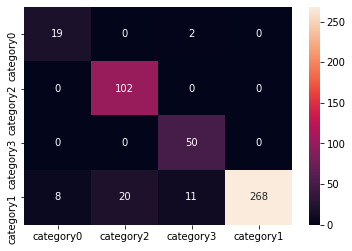

In [ ]:
classification_matrix_report()

# 96 x 96 Convolution layers


In [ ]:
IMG_HEIGHT = 96
IMG_WIDTH = 96

img_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model96 = keras.Sequential()

model96.add(keras.layers.Conv2D(64, 3, input_shape=(img_shape), activation='relu', padding='same'))
model96.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
model96.add(keras.layers.Dropout(0.2))
model96.add(keras.layers.MaxPool2D(2, 2))

prior = keras.models.load_model('trained_48.h5')

for layer in prior.layers[-12:]:
    layer.trainable = False

for layer in prior.layers[1:]:
    model96.add(layer)

model96.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)       

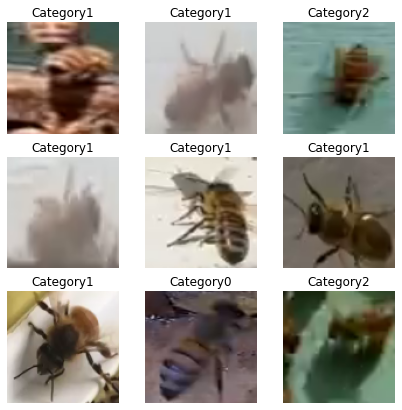

In [ ]:
train_ds_96, eval_ds_96, test_ds_96 = load_image(df1, df2, df3)


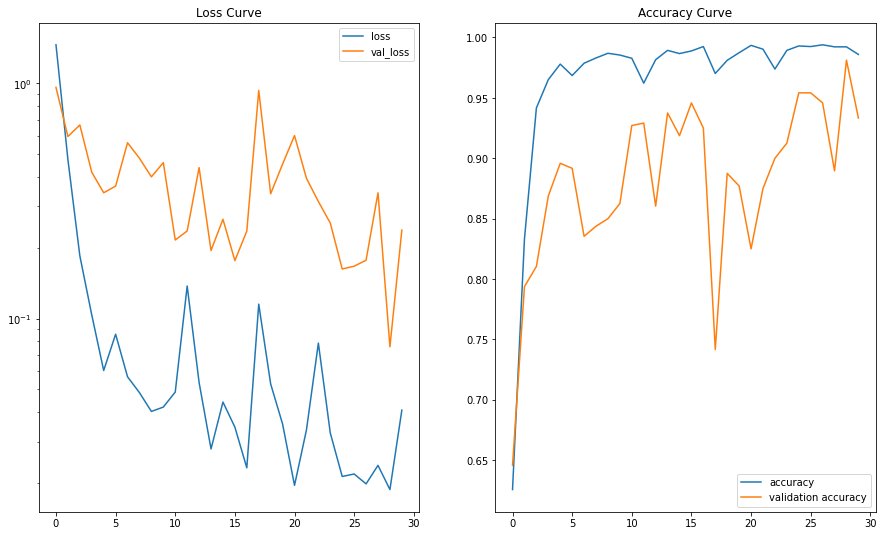

In [ ]:
reset_random_seeds()
model96 = modelfit(model96, train_ds_96, eval_ds_96, save='trained_96.h5')

In [ ]:
print_final_accuracy(model=model96, holdout=eval_ds_96, test=test_ds_96)

500/500 [==============================] - 4s 8ms/step - loss: 0.2387 - accuracy: 0.9340
Test loss: 0.2386905401945114
Test accuracy: 0.9340000152587891
------------------------------
500/500 [==============================] - 4s 8ms/step - loss: 0.2387 - accuracy: 0.9340
Eval loss: 0.23869071900844574
Eval accuracy: 0.9340000152587891


1/1 [==============================] - 0s 40ms/step
Confusion Matrix
[[  4   4   0  11]
 [  0 114   0   5]
 [  0   2  38  12]
 [  0   5   0 285]]
Classification Report
              precision    recall  f1-score   support

   category0       1.00      0.21      0.35        19
   category2       0.91      0.96      0.93       119
   category3       1.00      0.73      0.84        52
   category1       0.91      0.98      0.95       290

    accuracy                           0.92       480
   macro avg       0.96      0.72      0.77       480
weighted avg       0.92      0.92      0.91       480



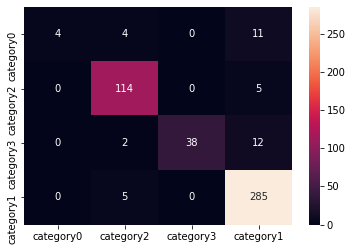

In [ ]:
classification_matrix_report(model=model96, test=test_ds_96)

In [ ]:
IMG_HEIGHT = 96*2
IMG_WIDTH = 96*2

img_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model192 = keras.Sequential()

model192.add(keras.layers.Conv2D(64, 3, input_shape=(img_shape), activation='relu', padding='same'))
model192.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
model192.add(keras.layers.Dropout(0.2))
model192.add(keras.layers.MaxPool2D(2, 2))

prior = keras.models.load_model('trained_96.h5')

for layer in prior.layers[-12:]:
    layer.trainable = False

for layer in prior.layers[1:]:
    model192.add(layer)

model192.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 192, 192, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 192, 192, 64)      36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 192, 192, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 96, 96, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)       

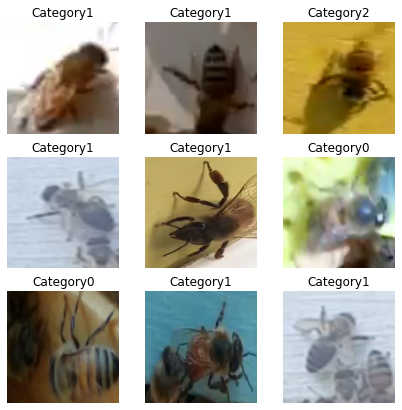

In [ ]:
train_ds_192, eval_ds_192, test_ds_192 = load_image(df1, df2, df3)


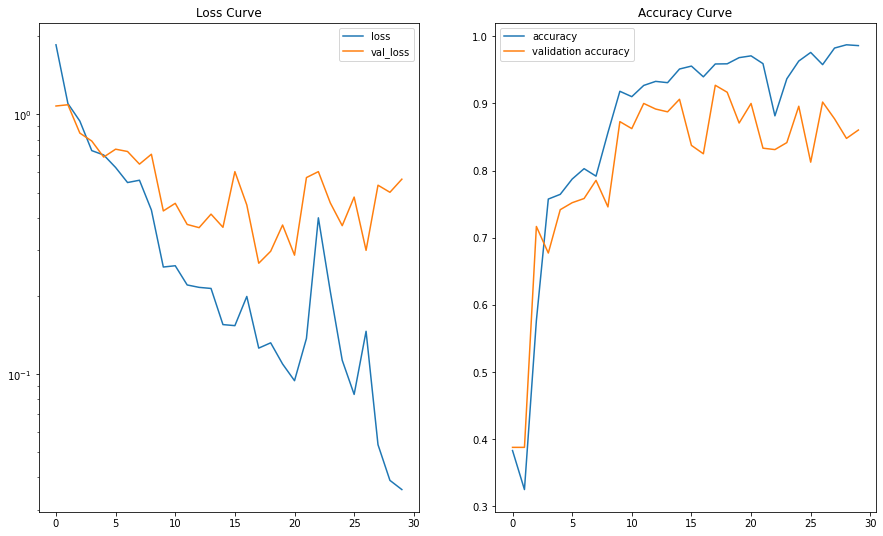

In [ ]:
reset_random_seeds()
model192 = modelfit(model192, train_ds_192, eval_ds_192, save='trained_192.h5')

In [ ]:
print_final_accuracy(model=model192, holdout=eval_ds_192, test=test_ds_192)

500/500 [==============================] - 15s 29ms/step - loss: 0.5498 - accuracy: 0.8640
Test loss: 0.5498270988464355
Test accuracy: 0.8640000224113464
------------------------------
500/500 [==============================] - 15s 29ms/step - loss: 0.5498 - accuracy: 0.8640
Eval loss: 0.5498270392417908
Eval accuracy: 0.8640000224113464


1/1 [==============================] - 0s 55ms/step
Confusion Matrix
[[  6   3   0   8]
 [  0  71   0  16]
 [  0   0   6  36]
 [  0   0   0 334]]
Classification Report
              precision    recall  f1-score   support

   category0       1.00      0.35      0.52        17
   category2       0.96      0.82      0.88        87
   category3       1.00      0.14      0.25        42
   category1       0.85      1.00      0.92       334

    accuracy                           0.87       480
   macro avg       0.95      0.58      0.64       480
weighted avg       0.89      0.87      0.84       480



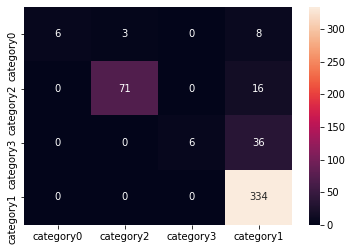

In [ ]:
classification_matrix_report(model=model192,test=test_ds_192)